In [26]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [16]:
file_path = "/Users/rishikabethi/Desktop/UrbanSound/archive"
file_viz = glob.glob('/Users/rishikabethi/Desktop/UrbanSound/archive/fold1/*')
urbansound8k = pd.read_csv("/Users/rishikabethi/Desktop/UrbanSound/UrbanSound8K.csv")

In [17]:
class_map = {'0' : 'air_conditioner',
             '1' : 'car_horn',
             '2' : 'children_playing', 
             '3' : 'dog_bark', 
             '4' : 'drilling', 
             '5' : 'engine_idling', 
             '6' : 'gun_shot',
             '7' : 'jackhammer',
             '8' : 'siren',
             '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [18]:
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [20]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, orig_sr=fsr, target_sr=sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('air_conditioner', (88200,)),
 ('car_horn', (10264,)),
 ('children_playing', (88200,)),
 ('dog_bark', (88200,)),
 ('drilling', (88200,)),
 ('engine_idling', (88200,)),
 ('gun_shot', (25104,)),
 ('jackhammer', (63284,)),
 ('siren', (88200,)),
 ('street_music', (88200,))]

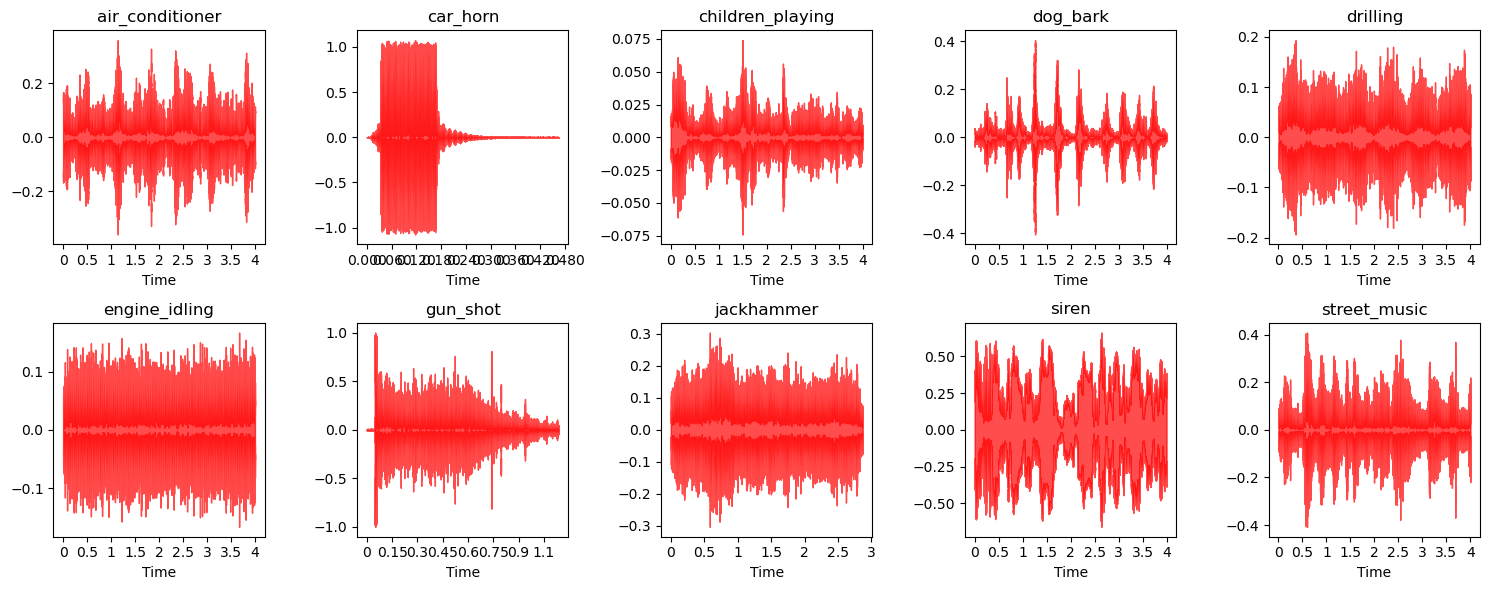

In [21]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveshow(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

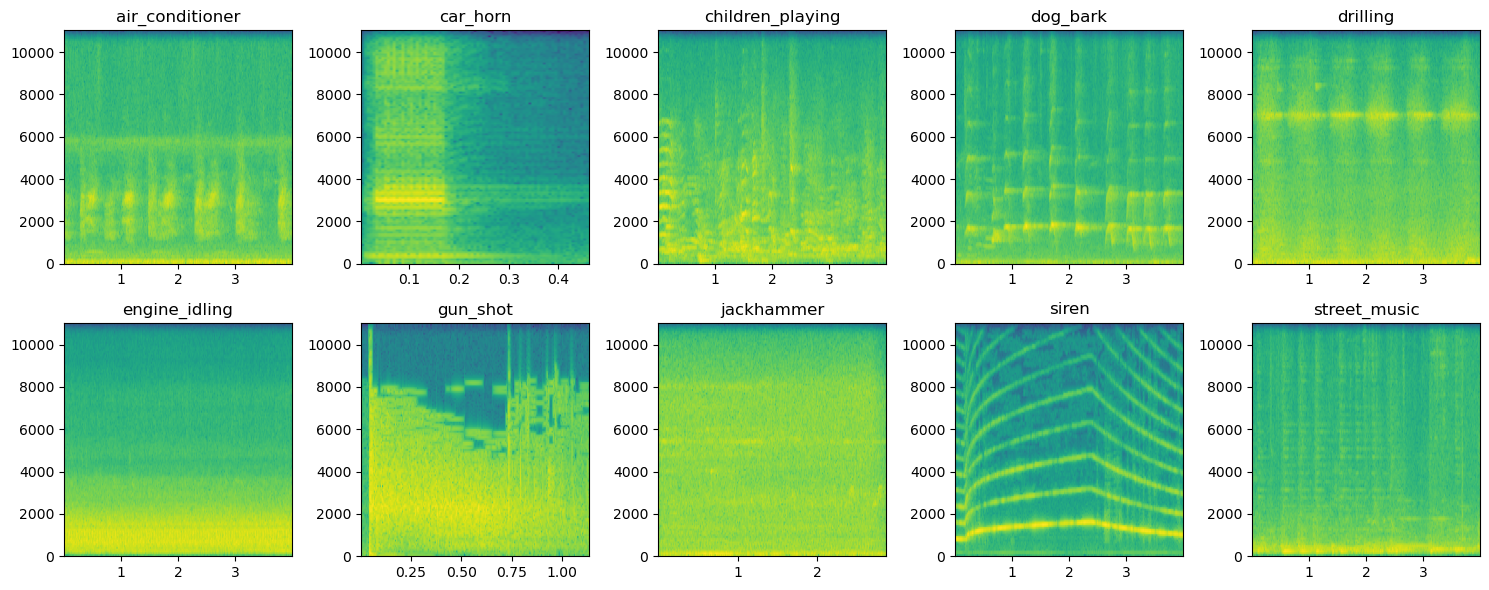

In [22]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

In [23]:
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [25]:
features = []

# Iterate through each sound file and extract the features 
for index, row in urbansound8k.iterrows():
    
    file_name = "/Users/rishikabethi/Desktop/UrbanSound/archive/fold"+str(row["fold"])+'/'+str(row["slice_file_name"])
    
    class_label = row["classID"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])


/Users/rishikabethi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/Users/rishikabethi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/rishikabethi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [27]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, random_state=3)

In [28]:
x_train1 = x_train 
x_test1 = x_test
y_train1 = y_train
y_test1 = y_test
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

5937
1747
5937
1747


In [29]:
x_test.shape[0]

1747

In [30]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
x_valid = x_valid.reshape(x_valid.shape[0], num_rows, num_columns, num_channels)
print(x_train.shape)

num_labels = yy.shape[1]
filter_size = 3

(5937, 40, 174, 1)


In [35]:
# Constructing model with RELu and SoftMax activation functions:
model_relu = Sequential()
model_relu.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))
model_relu.add(GlobalAveragePooling2D())
model_relu.add(Flatten())
model_relu.add(Dense(num_labels, activation='softmax'))

In [36]:
model_relu.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [37]:
model_relu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 19, 86, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 19, 86, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 9, 42, 32)        

In [38]:
num_epochs = 200
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history_relu = model_relu.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_valid, y_valid), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200


2023-07-11 12:12:49.196245: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - ETA: 0s - loss: 3.7191 - accuracy: 0.1819
Epoch 1: val_loss improved from inf to 2.09741, saving model to saved_models/weights.best.basic_cnn.hdf5
24/24 [==============================] - 22s 286ms/step - loss: 3.7191 - accuracy: 0.1819 - val_loss: 2.0974 - val_accuracy: 0.2385
Epoch 2/200
24/24 [==============================] - ETA: 0s - loss: 1.9025 - accuracy: 0.3205
Epoch 2: val_loss improved from 2.09741 to 1.83522, saving model to saved_models/weights.best.basic_cnn.hdf5
24/24 [==============================] - 5s 211ms/step - loss: 1.9025 - accuracy: 0.3205 - val_loss: 1.8352 - val_accuracy: 0.3855
Epoch 3/200
24/24 [==============================] - ETA: 0s - loss: 1.6749 - accuracy: 0.4106
Epoch 3: val_loss improved from 1.83522 to 1.64414, saving model to saved_models/weights.best.basic_cnn.hdf5
24/24 [==============================] - 6s 238ms/step - loss: 1.6749 - accuracy: 0.4106 - val_loss: 1.6441 - val_accuracy: 0.4637
Epoch 4/20

24/24 [==============================] - 5s 210ms/step - loss: 0.6787 - accuracy: 0.7711 - val_loss: 0.9432 - val_accuracy: 0.6775
Epoch 27/200
24/24 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.7635
Epoch 27: val_loss improved from 0.88211 to 0.85311, saving model to saved_models/weights.best.basic_cnn.hdf5
24/24 [==============================] - 5s 201ms/step - loss: 0.6887 - accuracy: 0.7635 - val_loss: 0.8531 - val_accuracy: 0.7156
Epoch 28/200
24/24 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.7824
Epoch 28: val_loss improved from 0.85311 to 0.81475, saving model to saved_models/weights.best.basic_cnn.hdf5
24/24 [==============================] - 5s 198ms/step - loss: 0.6520 - accuracy: 0.7824 - val_loss: 0.8148 - val_accuracy: 0.7405
Epoch 29/200
24/24 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.7846
Epoch 29: val_loss improved from 0.81475 to 0.79415, saving model to saved_models/weights.best.basi

Epoch 54/200
24/24 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.8696
Epoch 54: val_loss improved from 0.60275 to 0.60121, saving model to saved_models/weights.best.basic_cnn.hdf5
24/24 [==============================] - 5s 200ms/step - loss: 0.3969 - accuracy: 0.8696 - val_loss: 0.6012 - val_accuracy: 0.7996
Epoch 55/200
24/24 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8708
Epoch 55: val_loss did not improve from 0.60121
24/24 [==============================] - 4s 187ms/step - loss: 0.3874 - accuracy: 0.8708 - val_loss: 0.7870 - val_accuracy: 0.7471
Epoch 56/200
24/24 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.8679
Epoch 56: val_loss did not improve from 0.60121
24/24 [==============================] - 5s 195ms/step - loss: 0.3839 - accuracy: 0.8679 - val_loss: 0.6701 - val_accuracy: 0.7739
Epoch 57/200
24/24 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8715
Epoch 57: val_los

Epoch 82/200
24/24 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.9070
Epoch 82: val_loss improved from 0.43456 to 0.41444, saving model to saved_models/weights.best.basic_cnn.hdf5
24/24 [==============================] - 5s 200ms/step - loss: 0.2624 - accuracy: 0.9070 - val_loss: 0.4144 - val_accuracy: 0.8664
Epoch 83/200
24/24 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9136
Epoch 83: val_loss did not improve from 0.41444
24/24 [==============================] - 5s 198ms/step - loss: 0.2476 - accuracy: 0.9136 - val_loss: 0.4754 - val_accuracy: 0.8550
Epoch 84/200
24/24 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.9156
Epoch 84: val_loss did not improve from 0.41444
24/24 [==============================] - 4s 188ms/step - loss: 0.2503 - accuracy: 0.9156 - val_loss: 0.5424 - val_accuracy: 0.8206
Epoch 85/200
24/24 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.9087
Epoch 85: val_los

Epoch 111/200
24/24 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9348
Epoch 111: val_loss did not improve from 0.34608
24/24 [==============================] - 5s 209ms/step - loss: 0.1885 - accuracy: 0.9348 - val_loss: 0.4020 - val_accuracy: 0.8721
Epoch 112/200
24/24 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9384
Epoch 112: val_loss did not improve from 0.34608
24/24 [==============================] - 5s 196ms/step - loss: 0.1841 - accuracy: 0.9384 - val_loss: 0.4900 - val_accuracy: 0.8559
Epoch 113/200
24/24 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9377
Epoch 113: val_loss did not improve from 0.34608
24/24 [==============================] - 5s 206ms/step - loss: 0.1781 - accuracy: 0.9377 - val_loss: 0.4326 - val_accuracy: 0.8702
Epoch 114/200
24/24 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9392
Epoch 114: val_loss did not improve from 0.34608
24/24 [================

24/24 [==============================] - 4s 156ms/step - loss: 0.1354 - accuracy: 0.9562 - val_loss: 0.4591 - val_accuracy: 0.8712
Epoch 141/200
24/24 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9572
Epoch 141: val_loss did not improve from 0.31069
24/24 [==============================] - 4s 147ms/step - loss: 0.1300 - accuracy: 0.9572 - val_loss: 0.3441 - val_accuracy: 0.9036
Epoch 142/200
24/24 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.9560
Epoch 142: val_loss did not improve from 0.31069
24/24 [==============================] - 4s 153ms/step - loss: 0.1233 - accuracy: 0.9560 - val_loss: 0.4252 - val_accuracy: 0.8769
Epoch 143/200
24/24 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9500
Epoch 143: val_loss did not improve from 0.31069
24/24 [==============================] - 4s 158ms/step - loss: 0.1383 - accuracy: 0.9500 - val_loss: 0.3461 - val_accuracy: 0.9065
Epoch 144/200
24/24 [=================

Epoch 199/200
24/24 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9693
Epoch 199: val_loss did not improve from 0.30244
24/24 [==============================] - 4s 161ms/step - loss: 0.0906 - accuracy: 0.9693 - val_loss: 0.3550 - val_accuracy: 0.9036
Epoch 200/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0859 - accuracy: 0.9713
Epoch 200: val_loss did not improve from 0.30244
24/24 [==============================] - 3s 143ms/step - loss: 0.0860 - accuracy: 0.9712 - val_loss: 0.3209 - val_accuracy: 0.9189
Training completed in time:  0:15:36.266687


In [39]:
score = model_relu.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model_relu.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9814721345901489
Testing Accuracy:  0.900400698184967


In [41]:
y_pred=model.predict(x_test)

55/55 [==============================] - 1s 9ms/step


In [42]:
c_acc = tf.keras.metrics.CategoricalAccuracy()
c_acc.update_state(y_test,y_pred)
c_acc.result().numpy()

0.11390956

In [43]:
auc = tf.keras.metrics.AUC()
auc.update_state(y_test,y_pred)
auc.result().numpy()

0.5157002

In [44]:
recall = tf.keras.metrics.Recall()
recall.update_state(y_test,y_pred)
recall.result().numpy()

0.11390956

In [45]:
precision = tf.keras.metrics.Precision()
precision.update_state(y_test,y_pred)
precision.result().numpy()

0.11516204